## Mount GDrive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Convert cell images and label masks to COCO json format

In [3]:
"""
With this code, we will convert our labeled mask image annotations to coco json
format so they can be used in training Mask R-CNN.

"""

import os
import cv2
import numpy as np
import json
import shutil
from sklearn.model_selection import train_test_split

def get_image_mask_pairs(data_dir):
    image_paths = []
    mask_paths = []

    for root, _, files in os.walk(data_dir):
        if 'images' in root:
            for file in files:
                if file.endswith('.png'):
                    image_paths.append(os.path.join(root, file))
                    mask_paths.append(os.path.join(root.replace('images', 'masks'), file.replace('.png', '.png')))

    return image_paths, mask_paths

def mask_to_polygons(mask, epsilon=1.0):
    # Convert mask to grayscale if necessary
    if len(mask.shape) > 2:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    # Ensure mask is of type np.uint8
    mask = mask.astype(np.uint8)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    polygons = []
    for contour in contours:
        if len(contour) > 2:
            poly = contour.reshape(-1).tolist()
            if len(poly) > 4:  # Ensure valid polygon
                polygons.append(poly)
    return polygons


def process_data(image_paths, mask_paths, output_dir):
    annotations = []
    images = []
    image_id = 0
    ann_id = 0

    for img_path, mask_path in zip(image_paths, mask_paths):
        image_id += 1
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        # Copy image to output directory
        shutil.copy(img_path, os.path.join(output_dir, os.path.basename(img_path)))

        images.append({
            "id": image_id,
            "file_name": os.path.basename(img_path),
            "height": img.shape[0],
            "width": img.shape[1]
        })

        unique_values = np.unique(mask)
        for value in unique_values:
            if value == 0:  # Ignore background
                continue

            object_mask = (mask == value).astype(np.uint8) * 255
            polygons = mask_to_polygons(object_mask)

            for poly in polygons:
                ann_id += 1
                annotations.append({
                    "id": ann_id,
                    "image_id": image_id,
                    "category_id": 1,  # Only one category: Nuclei
                    "segmentation": [poly],
                    "area": cv2.contourArea(np.array(poly).reshape(-1, 2)),
                    "bbox": list(cv2.boundingRect(np.array(poly).reshape(-1, 2))),
                    "iscrowd": 0
                })

    coco_output = {
        "images": images,
        "annotations": annotations,
        "categories": [{"id": 1, "name": "Nuclei"}]
    }

    with open(os.path.join(output_dir, 'coco_annotations.json'), 'w') as f:
        json.dump(coco_output, f)

In [4]:
def main():
    data_dir = "/content/drive/MyDrive/Final IDCC-SAM/Dataset/Rebuttal/ADC/Train"
    output_dir = "/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/ADC/Mask RCNN/COCO_dataset"
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')

    # Create output directories
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    image_paths, mask_paths = get_image_mask_pairs(data_dir)
    print(len(image_paths), len(mask_paths))
    # Split data into train and val
    train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(image_paths, mask_paths, test_size=0.1, random_state=42)

    # Process train and val data
    process_data(train_img_paths, train_mask_paths, train_dir)
    process_data(val_img_paths, val_mask_paths, val_dir)

if __name__ == '__main__':
     main()


150 150


Display Sample COCO Labels

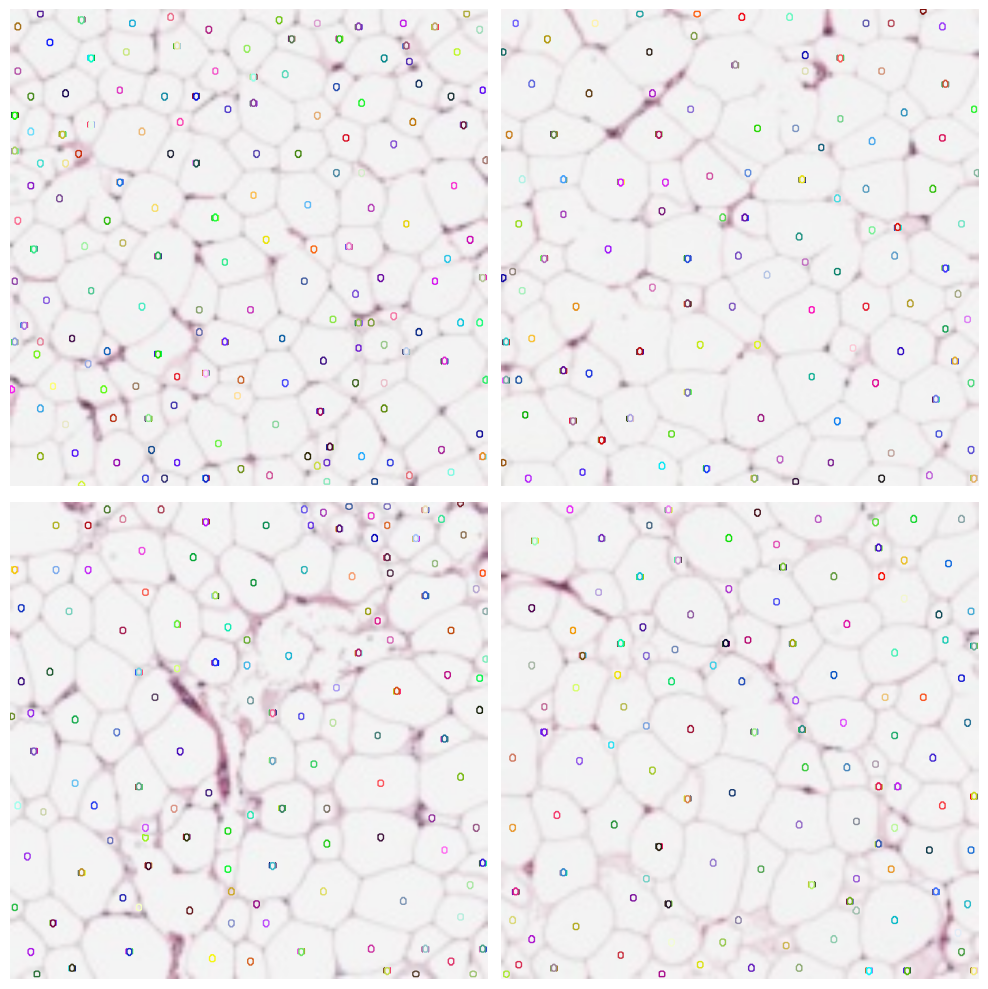

In [5]:
import os
import random
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import numpy as np

def display_images_with_coco_annotations(image_paths, annotations, display_type='both'):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    for ax, img_path in zip(axs.ravel(), image_paths):
        # Load image using OpenCV and convert it from BGR to RGB color space
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax.imshow(image)
        ax.axis('off')  # Turn off the axes

        # Get image filename to match with annotations
        img_filename = os.path.basename(img_path)
        img_id = next(item for item in annotations['images'] if item["file_name"] == img_filename)['id']

        # Filter annotations for the current image
        img_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == img_id]

        # Generate random colors for each annotation
        colors = [tuple(np.random.rand(3)) for _ in img_annotations]

        for ann, color in zip(img_annotations, colors):
            # Display bounding box
            if display_type in ['bbox', 'both']:
                bbox = ann['bbox']
                rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                                         linewidth=1, edgecolor=color,
                                         facecolor='none')
                ax.add_patch(rect)

            # Display segmentation polygon
            if display_type in ['seg', 'both']:
                for seg in ann['segmentation']:
                    poly = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
                    polygon = patches.Polygon(poly, closed=True, edgecolor=color,
                                              fill=False)
                    ax.add_patch(polygon)

    plt.tight_layout()
    plt.show()

# Load COCO annotations
with open('/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/ADC/Mask RCNN/COCO_dataset/train/coco_annotations.json', 'r') as f:
    annotations = json.load(f)

# Get all image files
image_dir = "/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/ADC/Mask RCNN/COCO_dataset/train/"
all_image_files = [os.path.join(image_dir, img['file_name']) for img in annotations['images']]
random_image_files = random.sample(all_image_files, 4)

# Choose between 'bbox', 'seg', or 'both'
display_type = 'seg'
display_images_with_coco_annotations(random_image_files, annotations, display_type)
